# Timetree Analysis

1. Plot root-to-tip regression with date (tips).
1. Estimate a time-scaled phylogeny.
1. Plot root-to-tip regression with date (tips+internals)
1. Plot timetree.


**TO-DO**:

* [x] Identify if the local branch_length change is significant.  
    Conclusion: IT IS NOT!


    ```python
    # Line 403 of the treeanc.py file
    # self.tree.root.branch_length = 0.001
    self.tree.root.branch_length = self.tree.root.branch_length
    ```
    
* [x] Fix up some plotting parameters:
    - Add the Low Confidence legend element
    - Remove y ticks
  
* [x] Add stats to the dataframe including:
    - date
    - date confidence
    - timetree x and y coordinates (to plot nodes)
* [x] Side by side divtree and timetree

1. Refine timetree parameters, specifically:
    - Relaxed clock
    - Marginal date estimation and confidence
1. Plot subtrees
    - Second pandemic

In [118]:
import treetime
import matplotlib.pyplot as plt
from matplotlib import patches, lines, gridspec
from Bio import Phylo
import os
import numpy as np
import pandas as pd
import random
import math
import copy
import scipy

#pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option("display.max_rows", 10, "display.max_columns", 10)
random.seed(1152342, 2)

tree_path = "../../docs/results/latest/branch_support/branch_support.nwk"
#metadata_path = "../../docs/results/latest/metadata/metadata.tsv"
metadata_path = "../../docs/results/latest/mugration/mugration.tsv"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"
outdir = "../../docs/results/latest/timetree/"

# Font
SM_FONT = 5
MED_FONT = 8
LG_FONT = 10

figsize_alt=(9.6,4.8)

plt.rc('font', size=SM_FONT)          # controls default text sizes
plt.rc('figure', titlesize=LG_FONT)  # fontsize of the figure title
plt.rc('legend', title_fontsize=MED_FONT)  # fontsize of the legend title
plt.rc('legend', frameon=False)  # legend frame
plt.rc('axes', labelsize=MED_FONT)    # fontsize of the x and y labels
plt.rc('axes', titlesize=LG_FONT) # fontsize of axis titles
plt.rc('lines', linewidth=2)
plt.rc('legend', labelspacing=0.75)
dpi = 400

NO_DATA_CHAR = "NA"
DATE_COL = "Date"
TERM_COL = "grey"
#NAME_COL = "Sample"
NAME_COL = "Name"
REF_DATE = 1992.0
REF_LEN = 4653728
CONFIDENCE=0.95
N_IQD=3

COLOR_PAL = "tab10"
CMAP_N = 10
cmap = plt.get_cmap(COLOR_PAL, CMAP_N)
cmaplist = [cmap(i) for i in range(cmap.N)]

MUG_ATTR = "Branch_Major"

## Functions

In [3]:
# This code is from the biopython Phylo module

def get_x_positions(tree):
    """Create a mapping of each clade to its horizontal position.
    Dict of {clade: x-coord}
    """
    depths = tree.depths()
    # If there are no branch lengths, assume unit branch lengths
    if not max(depths.values()):
        depths = tree.depths(unit_branch_lengths=True)
    return depths

def get_y_positions(tree):
    """Create a mapping of each clade to its vertical position.
    Dict of {clade: y-coord}.
    Coordinates are negative, and integers for tips.
    """
    maxheight = tree.count_terminals()
    # Rows are defined by the tips
    heights = {
        tip: maxheight - i for i, tip in enumerate(reversed(tree.get_terminals()))
    }

    # Internal nodes: place at midpoint of children
    def calc_row(clade):
        for subclade in clade:
            if subclade not in heights:
                calc_row(subclade)
        # Closure over heights
        heights[clade] = (
            heights[clade.clades[0]] + heights[clade.clades[-1]]
        ) / 2.0

    if tree.root.clades:
        calc_row(tree.root)
    return heights

### Create a basic TimeTree Object

In [4]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(metadata_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v

# Add the reference date
dates["Reference"] = REF_DATE

# Construct the treetime object
tt = treetime.TreeTime(dates=dates, 
                       aln=aln_path,
                       tree=tree_path, 
                       seq_len=REF_LEN,
                       verbose=4, 
                       fill_overhangs=False,)

# Remove outliers
tt.clock_filter(reroot=None, 
                n_iqd=N_IQD, 
                plot=False,
               )


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.

0.00	-TreeAnc: set-up

0.95	-SequenceData: loaded alignment.
0.95	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

0.95	-SeqData: making compressed alignment...

3.54	-SequenceData: constructed compressed alignment...
3.79	--ClockTree: Setting precision to level 2

3.84	-ClockTree._assign_dates: assigned date contraints to 523 out of 523 tips.
4.05	--ClockTree.date2dist: Setting new molecular clock. rate=9.668e-09,
    	  R^2=0.2481


'success'

### Run Clock Analysis

In [5]:
# PARAM SET 1: date='-4262-12-02'
#tt.run()

# PARAM SET 3
# Resolve polytomies might be problematic, nodes are being deleted and recreated.
# This may affect my node dataframe
#tt.run(root=None, infer_gtr=True, relaxed_clock=False, max_iter=1,
#                    branch_length_mode='input', n_iqd=3, resolve_polytomies=False,
#                    Tc='skyline', time_marginal="assign", vary_rate=True)

# PARAM SET 3
# Safe: Don't resolve polytomies
# Safe: Remove time_marginal,
tt.run(resolve_polytomies=False)


8.12	-TreeTime._set_branch_length_mode: maximum branch length is 3.648e-05,
    	 using branch length mode joint

8.12	-TreeAnc.optimize_tree: sequences...

8.12	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

8.12	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
8.12	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
8.12	---TreeAnc._ml_anc_joint: Walking up the tree, computing likelihoods...
13.15	---TreeAnc._ml_anc_joint: Walking down the tree, computing maximum
     	   likelihood sequences...
13.28	---TreeAnc._ml_anc_joint: ...done
13.30	--TreeAnc.infer_gtr: counting mutations...
14.62	---TreeAnc.infer_gtr: counting mutations...done

14.62	-G

'success'

In [7]:
# Quick check
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch_length=0.001, clock_length=0.001, date='-4098-07-15', dist2root=0.0, mutation_length=0.001, name='NODE0', original_length=0.0)

### Add timetree info to dataframe

In [8]:
tree_df = pd.read_csv(metadata_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()
tt_copy.tree.ladderize(reverse=True)

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Create new columns
tree_df[DATE_COL + "_timetree"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Add x and y coordinates
for c in tt_copy.tree.find_clades():
    # Remove the mysterious NODE_ nodes
    if not c.name or "NODE_" in c.name: continue
        
    # Add dates and confidence
    tree_df.at[c.name, DATE_COL + "_timetree"] = c.numdate
    #conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
    #tree_df.at[c.name, DATE_COL + "_timetree_conf"] = conf
    
    # Scatter coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad
    
tree_df

94.79	--ClockTree.branch_length_to_years: setting node positions in units of
     	  years


,UFboot,aLRT,Branch_Length,Branch_Support_Color,coord_x,...,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,
NODE0,100,100,0.000000e+00,red,0.000000,...,0.1,506.918,-4097.46,0,False
NODE1,100,99.9,5.224800e-06,red,0.000005,...,393.303,490.836,-3704.26,4.73006e-06,False
NODE2,100,100,1.823010e-05,red,0.000023,...,1428.11,466.171,-2669.45,2.0664e-05,False
NODE3,100,100,1.067900e-05,red,0.000034,...,2334.33,432.716,-1763.23,3.03443e-05,False
NODE4,100,97.9,2.123000e-06,red,0.000036,...,2671.47,396.431,-1426.09,3.22787e-05,False
...,...,...,...,...,...,...,...,...,...,...,...
SAMEA104233049,NA,NA,1.871000e-07,grey,0.000037,...,1835.99,519,-2272,3.27093e-05,False
SAMEA104233047,NA,NA,4.923000e-07,grey,0.000025,...,1523.56,520,-2457,1.93638e-05,False
SAMEA104233050,NA,NA,1.006000e-06,grey,0.000016,...,1214.56,521,-2762.5,1.33404e-05,False


## Root To Tip Regression

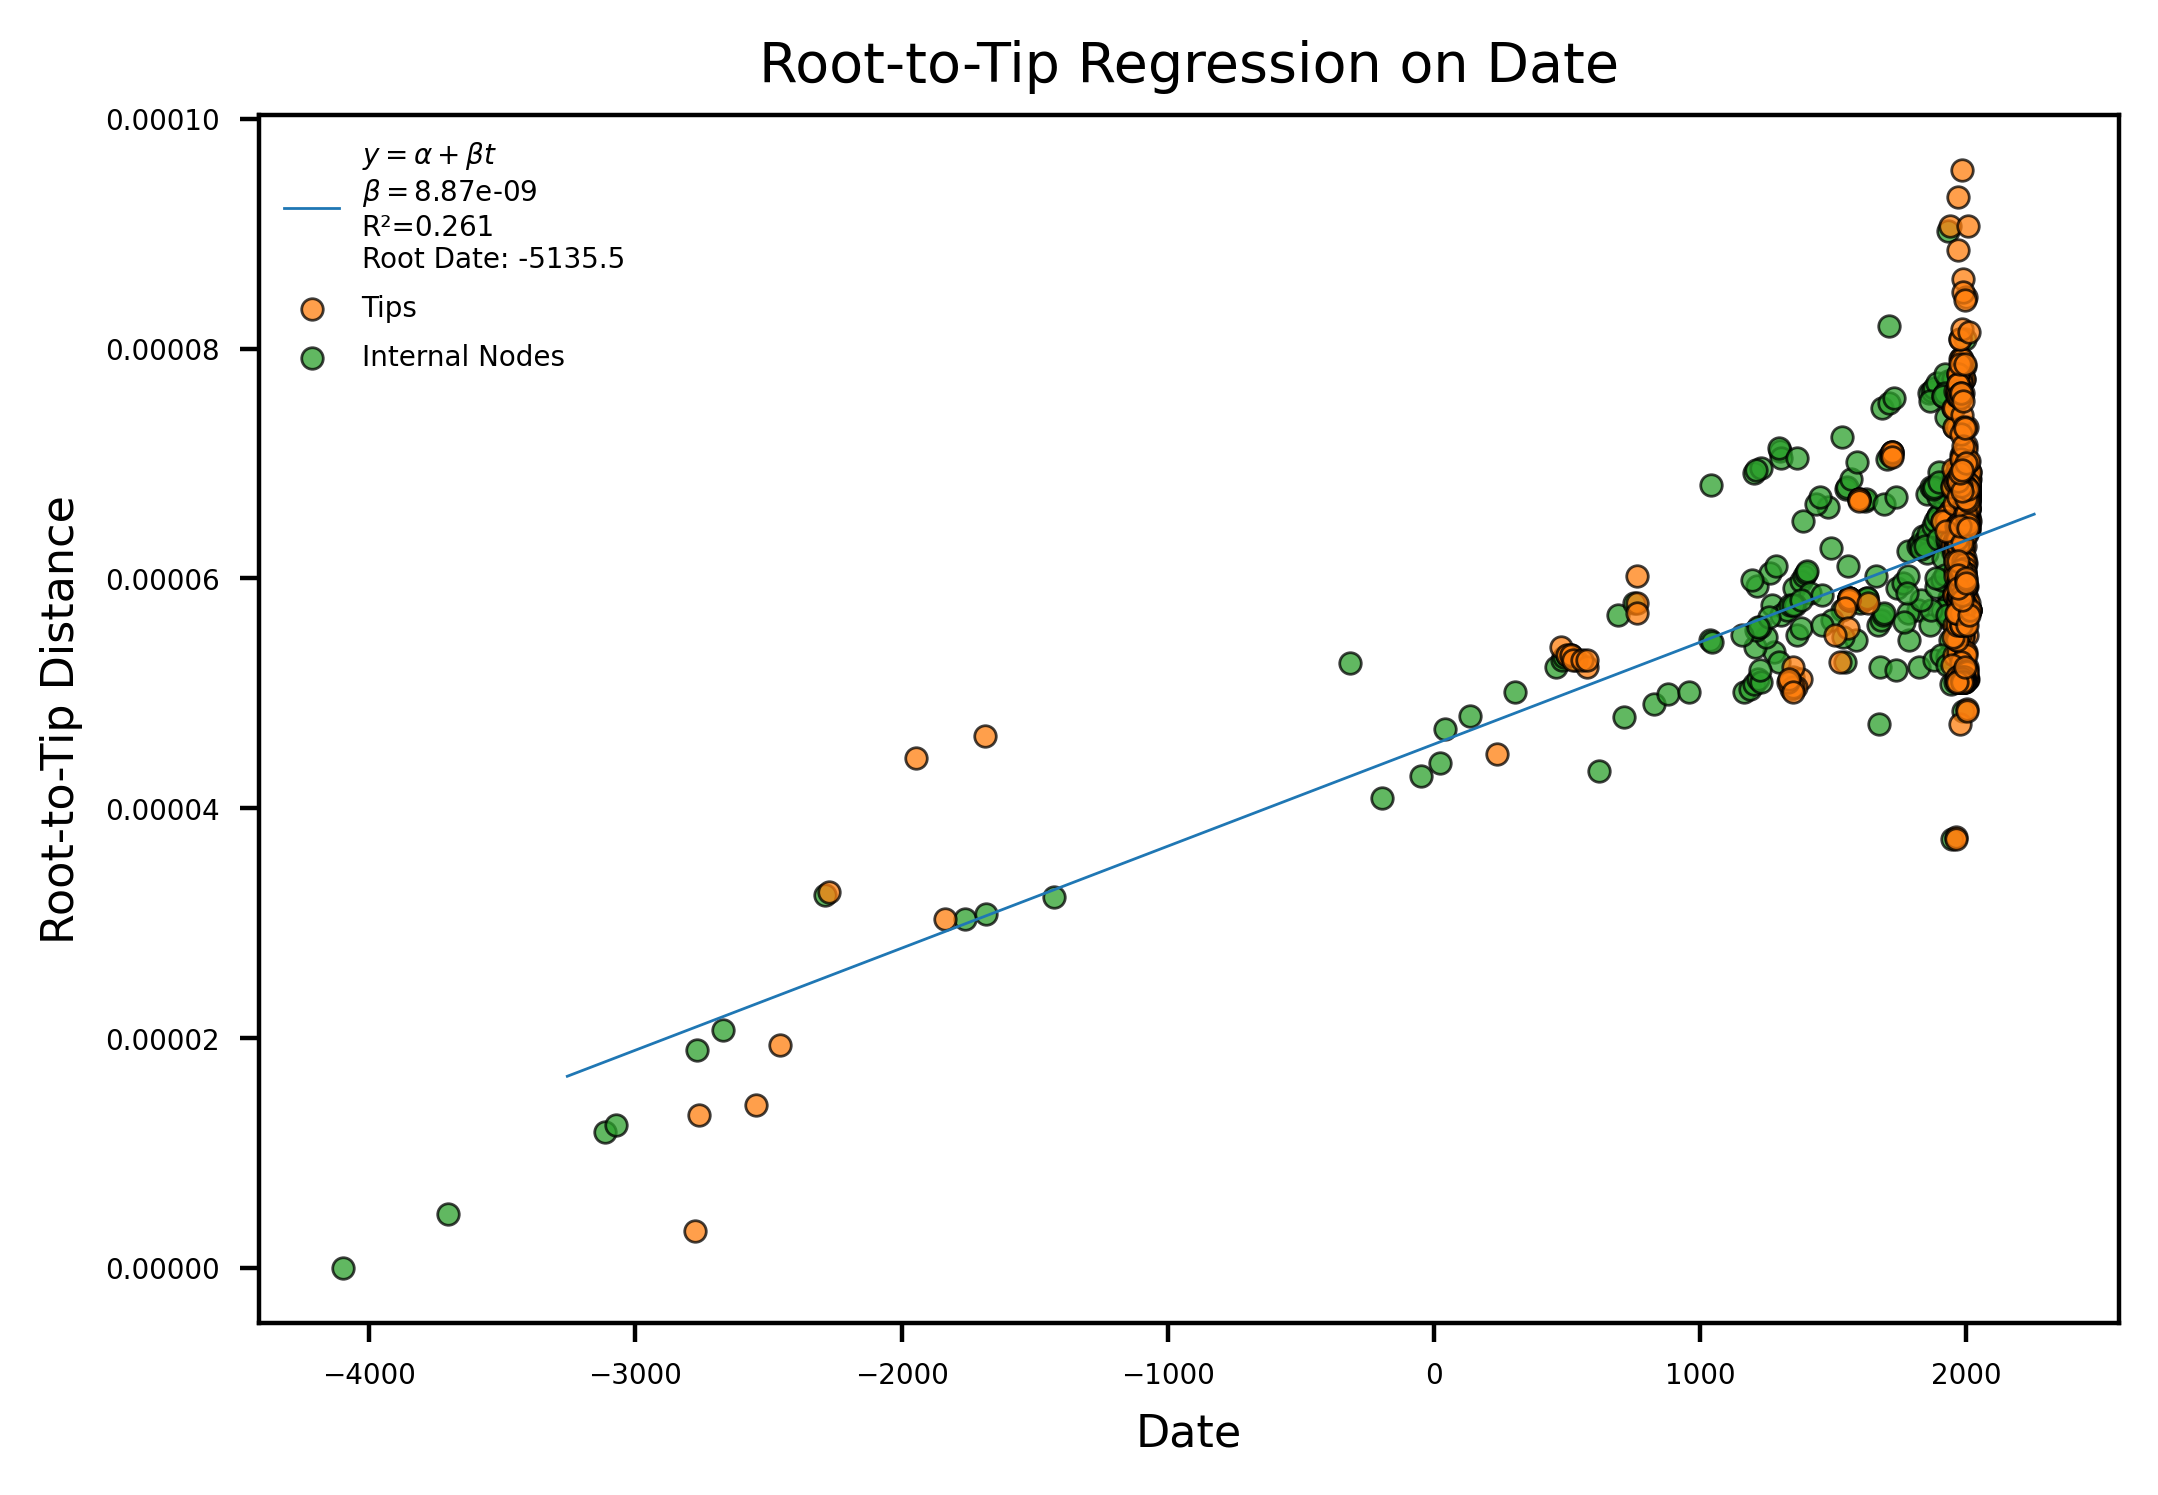

In [120]:
# Root to tip regression
fig, (ax1) = plt.subplots(1, dpi=400)

tip_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) & (tree_df["Branch_Support_Color"] == TERM_COL)]
int_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) & (tree_df["Branch_Support_Color"] != TERM_COL)]
regression = tt.clock_model
t_mrca = -regression['intercept']/regression['slope']
# This does not filter for bad branches!
time_span = np.max(tip_data["timetree_reg_x"]) - np.min(tip_data["timetree_reg_x"])
x_vals = np.array([max(np.min(tip_data["timetree_reg_x"]), t_mrca) - 0.1*time_span, 
                   np.max(tip_data["timetree_reg_x"]+0.05*time_span)])

res = scipy.stats.linregress(list(tip_data["timetree_reg_x"]),list(tip_data["timetree_reg_y"]))

# When no confidence is enabled
dev_rtt = None
dev_slope = None

# Plot tips
ax1.scatter(data=tip_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Tips",
            color=cmaplist[1],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=2,)

# Plot internal nodes
ax1.scatter(data=int_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Internal Nodes",
            color=cmaplist[2],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=1,)

# Regression line
ax1.plot(x_vals, 
         regression['slope']*x_vals + regression['intercept'],
         label = r"$y=\alpha + \beta t$"+"\n"+
                r"$\beta=$%1.2e"%(regression["slope"])
                + ("+/- %1.e"%dev_slope if dev_slope else "") +
                "\nR²={:.3f}".format(res.rvalue**2) +
                "\nRoot Date: %1.1f"%(-regression['intercept']/regression['slope']) +
                ("+/- %1.2f"%dev_rtt if dev_rtt else ""),
         color=cmaplist[0],
        )

# Labels
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")
ax1.set_title("Root-to-Tip Regression on Date")
# Legend
plt.legend(loc=2)

# Save
out_path = os.path.join(outdir, "timetree_rtt.jpg") 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

---
# Plot Trees

### Events of import

In [115]:
tt_copy = copy.deepcopy(tt)
tt_copy.tree.ladderize(reverse=True)
black_death_node = tt_copy.tree.common_ancestor("SAMN00715800") # black death node: 8291
justinian_plague_node = tt_copy.tree.common_ancestor("SAMEA4354665") #justinian plague node: AE1175 
second_pandemic_mrca = tt_copy.tree.common_ancestor("SAMN00715800","SAMEA3713715", "SAMEA5818822") # 8291, OBS137, STN008
third_pandemic_tips = list(tree_df[(tree_df["Branch_Major"] == "1.ORI")].index)
third_pandemic_mrca = tt_copy.tree.common_ancestor(third_pandemic_tips)

target_attr = {"2.ANT": '', "2.MED": '', "3.ANT": "", "4.ANT": ""}
for c in tt_copy.tree.get_terminals():
    mug_val = tree_df[MUG_ATTR][c.name]
    if mug_val in target_attr and not target_attr[mug_val]:
        target_attr[mug_val] = c
        
big_bang_node = tt_copy.tree.common_ancestor(list(target_attr.values()))

### Import the divergence tree

In [48]:
tree_div = Phylo.read(tree_path, "newick")
tree_div.ladderize(reverse=False)
#Phylo.draw(tree_div)

## Color Clades

Using a mugration attribute (example major branch)

div tree then time tree

In [49]:
for c in tree_div.find_clades():
    # Remove the mysterious NODE_ nodes
    if not c.name or "NODE_" in c.name: continue   
    mug_val = tree_df["Mugration_" + MUG_ATTR][c.name]
    mug_color = tree_df["Mugration_" + MUG_ATTR + "_Color"][c.name]
    c.color = mug_color

In [50]:
# Color branches by a mugration attribute
mug_dict = {MUG_ATTR: {"hex_color": {}}}

# Deepest nodes first 
tt.tree.ladderize(reverse=False)  

# Change the branch color based on a mugration attribute
for c in tt.tree.find_clades():
    # Remove the mysterious NODE_ nodes
    if not c.name or "NODE_" in c.name: continue   
    mug_val = tree_df["Mugration_" + MUG_ATTR][c.name]
    mug_color = tree_df["Mugration_" + MUG_ATTR + "_Color"][c.name]
    # If it's not an nan
    if not pd.isnull(mug_color):
        c.color = mug_color
    if not pd.isnull(mug_val) and c.is_terminal():
        mug_dict[MUG_ATTR]["hex_color"][mug_val] = mug_color

# Add low confidence color
mug_dict[MUG_ATTR]["hex_color"]["Low Confidence"] = "grey"

### Plot Full Timetree

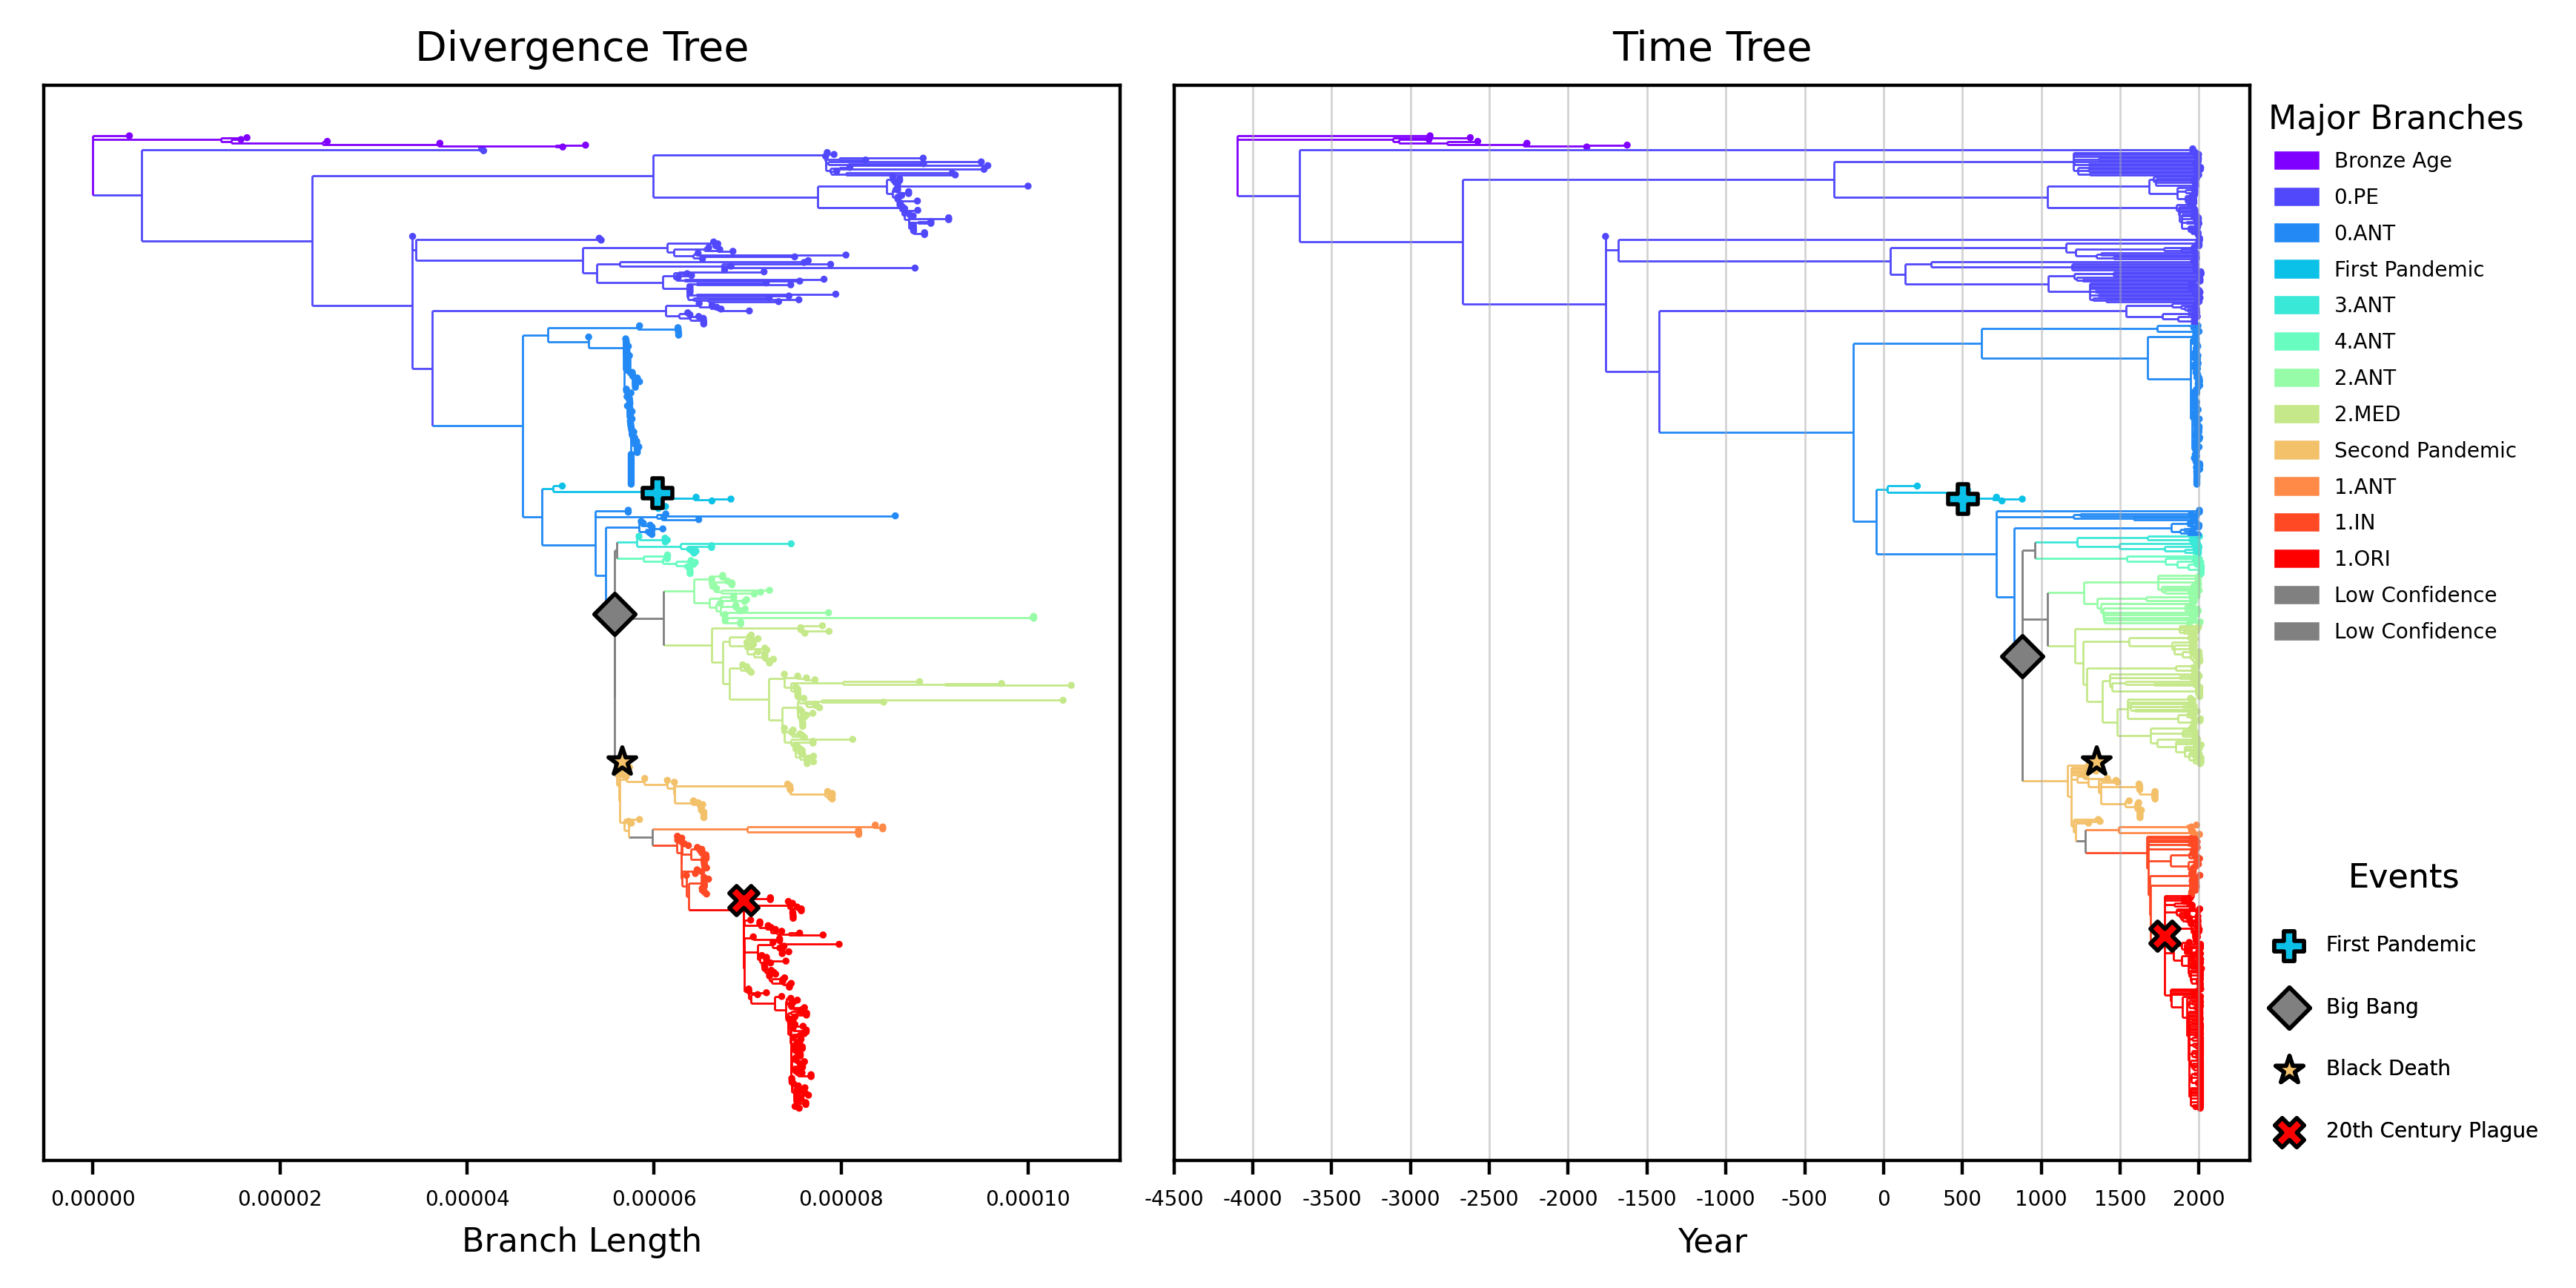

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, 
                         dpi=dpi, 
                         gridspec_kw={'wspace': 0.05}, 
                         figsize=figsize_alt,
                         sharey=True,
                         )

plt.rc('lines', linewidth=0.5)
# --------------------------------------------
# Draw trees
for t,ax in zip([tree_div, tt.tree], [ax1, ax2]):
    t.ladderize(reverse=True)
    #? tt.branch_length_to_years()
    Phylo.draw(t, 
           axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)
# --------------------------------------------
# Draw tips
tip_div_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
tip_time_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL) & (tree_df["timetree_coord_x"] != NO_DATA_CHAR)]
for df,ax,prefix in zip([tip_div_data, tip_time_data], [ax1, ax2], ["coord_", "timetree_coord_"]):
    ax.scatter(data=df,
               x=prefix + "x", 
               y=prefix + "y",
               s=0.5, 
               c="Mugration_" + MUG_ATTR + "_Color",
               label="",)

# --------------------------------------------
# Draw events
event_marker_size = 50
event_dict = {
    "First Pandemic": {
        "node": justinian_plague_node,
        "marker": "P",
        "color": mug_dict[MUG_ATTR]["hex_color"]["First Pandemic"],
    }, 
    "Big Bang": {
        "node": big_bang_node,
        "marker": "D",
        "color": mug_dict[MUG_ATTR]["hex_color"]["Low Confidence"],
    },
    "Black Death" : {
        "node": black_death_node,
        "marker": "*",
        "color": mug_dict[MUG_ATTR]["hex_color"]["Second Pandemic"],
    },
    "20th Century Plague": {
        "node" : third_pandemic_mrca,
        "marker" : "X",
        "color": mug_dict[MUG_ATTR]["hex_color"]["1.ORI"],
    }}

for event in event_dict:
    # shift markers up
    y_shift = 5
    # plot on both axes
    ax1.scatter(
        x = tree_df["coord_x"][event_dict[event]["node"].name], 
        y = tree_df["coord_y"][event_dict[event]["node"].name] + y_shift,
        marker=event_dict[event]["marker"], 
        label=event, 
        color=event_dict[event]["color"], 
        ec="black",
        s=event_marker_size,
        zorder=3,
        )    
    ax2.scatter(
        x = tree_df["timetree_coord_x"][event_dict[event]["node"].name], 
        y = tree_df["timetree_coord_y"][event_dict[event]["node"].name] + y_shift,
        marker=event_dict[event]["marker"], 
        label=event, 
        color=event_dict[event]["color"], 
        ec="black",
        s=event_marker_size,
        zorder=3,
        )

# --------------------------------------------
# Labels

ax1.set_xlabel('Branch Length')
ax1.set_ylabel('')    

ax2.set_xlabel('Year')
ax2.set_ylabel('')

ax1.set_title("Divergence Tree")
ax2.set_title("Time Tree")

# --------------------------------------------
# Ticks

# The y axis is not particularly meaning, remove the ticks
ax1.set_yticks([])
ax2.set_yticks([])

# Rescale the timetree access to calendar dates
# Step 1: Figure out offset to convert year branch length to calendar date
min_date = tt.tree.root.numdate - tt.tree.root.branch_length
max_date = np.max([n.numdate for n in tt.tree.get_terminals()])
offset = min_date
date_range = np.max([n.numdate for n in tt.tree.get_terminals()]) - min_date

# Step 2: Relabel xticks and space them differently
step = 500
# Distance between ticks
dtick = step
# Minimum tick value
min_tick = step*(offset//step)

# Extra tick increment
extra = dtick if dtick<date_range else dtick
# New tick values
tick_vals = np.arange(min_tick, min_tick+date_range+extra, dtick)
# New tick locations
tick_locs = tick_vals - offset
# New tick labels
tick_labels = ["%d"%(int(x)) for x in tick_vals]

# Set the new tick locations and labels
ax2.set_xticks(tick_locs)
ax2.set_xticklabels(tick_labels)

# --------------------------------------------
# Lines

# Vertical lines for dates
for loc in tick_locs:
    ax2.axvline(x=loc, color="darkgrey", alpha=0.5)

# --------------------------------------------
# Limits

x_buffer = max(tree_df["coord_x"]) * 0.05
y_buffer = math.ceil(len(tree_div.get_terminals()) * 0.01)

ax1.set_xlim(0 - x_buffer, max(tree_df["coord_x"]) + x_buffer)
ax1.set_ylim(0 - y_buffer,len(tree_div.get_terminals()) + y_buffer)

x_buffer = math.ceil((tick_locs[-1] - tick_locs[0]) * 0.05)
y_buffer = math.ceil(len(tt.tree.get_terminals()) * 0.05)

# No x buffer on lower end
ax2.set_xlim(tick_locs[0], tick_locs[-1] + x_buffer)
ax2.set_ylim(0 - y_buffer,len(tt.tree.get_terminals()) + y_buffer)

# --------------------------------------------
# Legends

# Make a custom patches legend for the mugration attribute
legend_mug_elements = [patches.Patch(facecolor=value, edgecolor=value,) for value in mug_dict[MUG_ATTR]["hex_color"].values()]
legend_mug_labels = list(mug_dict[MUG_ATTR]["hex_color"].keys())
# Add low confidence
legend_mug_elements += [patches.Patch(facecolor="grey", edgecolor="grey",)]
legend_mug_labels += ["Low Confidence"]

legend_mug = ax2.legend(legend_mug_elements, 
           legend_mug_labels, 
           bbox_to_anchor=(1.0, 1.0), 
           loc='upper left', 
           title="Major Branches",)

legend_events = ax2.legend(bbox_to_anchor=(1.0, 0.00), 
           loc='lower left',
           title="Events",
           labelspacing=2,)

# Add multiple legends as artists
ax2.add_artist(legend_mug)
ax2.add_artist(legend_events)

# --------------------------------------------
# Save
out_path = os.path.join(outdir, "timetree_divtree_{}.jpg".format(MUG_ATTR.lower()))  
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Black Death / Second Pandemic

I want this to be a subtree that starts at the common ancestor of all the "Second Pandemic" strains. I also want to be able to collapse/prune(?) the clades that come after the Second Pandemic: 1.ANT, 1.IN, 1.ORI

In [ ]:
tt_copy = copy.deepcopy(tt)

black_death = tt_copy.tree.common_ancestor("SAMN00715800") # black death node: 8291
justinian_plague = tt_copy.tree.common_ancestor("SAMEA4354665") #justinian plague node: AE1175 
second_pandemic_mrca = tt_copy.tree.common_ancestor("SAMN00715800","SAMEA3713715", "SAMEA5818822") # 8291, OBS137, STN008

fig = plt.figure(dpi=400)
ax1 = plt.subplot()

# Second Pandemic subtree

# Identify the node that is the common ancestor of 1.ANT and 1.IN and 1.ORI
# In testing, it's Node17 I believe
target_attr = {"1.ORI": '', "1.IN": '', "1.ANT": ''}
for c in second_pandemic_mrca.get_terminals():
    mug_val = tree_df[MUG_ATTR][c.name]
    if mug_val in target_attr and not target_attr[mug_val]:
        target_attr[mug_val] = c

collapse_node = second_pandemic_mrca.common_ancestor(list(target_attr.values()))

# Collapse all children of the collapse node
for c in collapse_node.find_clades():
    second_pandemic_mrca.collapse(target=c.name)

plt.rc('lines', linewidth=1)
tt.tree.ladderize(reverse=False)  
Phylo.draw(second_pandemic_mrca, 
           axes=ax1,
           show_confidence=False, 
           label_func = lambda x: tree_df["Strain"][x.name] if tree_df["Strain"][x.name] != "NA" else "", 
           do_show=False)
ax1.set_title("Second Pandemic")

### Skyline plot

In [ ]:
#treetime.wrappers.print_save_plot_skyline(tt, n_std=2.0, screen=True, save=False, plot=True)

In [ ]:
"""fig = plt.figure(dpi=dpi)
ax1 = plt.subplot()


# search for the first 1.ORI branch
second_pandemic_mrca = tt.tree.common_ancestor("SAMEA3713715", "SAMEA5818822") # 8291, OBS137, STN008

MUG_TARGET = "1.IN"
tt.tree.ladderize(reverse=False)
for c in tt.tree.find_clades():
    if  tree_df["Mugration_" + MUG_ATTR][c.name] == MUG_TARGET:
        MUG_TARGET_NODE = c
        break
        
print("Target: ", MUG_TARGET_NODE, type(MUG_TARGET_NODE))

for c in MUG_TARGET_NODE.find_clades():
    print(c)
#second_pandemic_mrca.collapse("NODE18")

print(second_pandemic_mrca)
Phylo.draw(second_pandemic_mrca, 
           axes=ax1,
           show_confidence=False, 
           label_func = lambda x: tree_df["Strain"][x.name] if tree_df["Strain"][x.name] != "NA" else "", 
           #label_func = lambda x: tree_df["Mugration_Branch_Major"][x.name],
           #label_func = lambda x: x,
           do_show=False)

ax1.set_title("Second Pandemic")
"""


# Save

In [ ]:
# Save tree dataframe with clock info
out_path = os.path.join(outdir, "timetree.tsv" )
tree_df.to_csv(out_path, sep="\t")